In [1]:
import os
from datetime import timedelta

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
from scipy import stats

load_dotenv()

sql_username = os.getenv('db_username')
sql_password = os.getenv('db_password')
sql_host = os.getenv('db_hostname')
sql_database = os.getenv('db_database')

url_string = f"mysql+pymysql://{sql_username}:{sql_password}@{sql_host}:3306/{sql_database}"
TABLE = "research_experiment_refactor_test"

engine = create_engine(url_string)

SELECTED_METRICS = [
    "Jump Height(m)",
    "Peak Propulsive Power(W)",
    "distance_total",
    "accel_load_accum",
    "leftMaxForce",
    "rightMaxForce"
]

sns.set(style="whitegrid")



In [32]:
TEAM_A = "Stony Brook Men's Basketball"
TEAM_B = "Stony Brook Women's Basketball"
METRIC_FOR_COMPARISON = "Jump Height(m)"

query = f"""
    SELECT playername, team, metric, value, timestamp
    FROM {TABLE}
    WHERE metric = '{METRIC_FOR_COMPARISON}'
      AND value IS NOT NULL
      AND team LIKE '%%Stony Brook%%'
"""

df_all = pd.read_sql(query, engine)
df_all["timestamp"] = pd.to_datetime(df_all["timestamp"])

df_men = df_all[df_all["team"].str.contains("Stony Brook Men's Basketball", na=False)].copy()
df_women = df_all[df_all["team"].str.contains("Stony Brook Women's Basketball", na=False)].copy()

df_men["group"] = TEAM_A
df_women["group"] = TEAM_B

df_comp = pd.concat([df_men, df_women], ignore_index=True)
df_comp.head()


,playername,team,metric,value,timestamp,group
0,PLAYER_430,"Group: Men's Basketball, Group: 21-22, Team: S...",Jump Height(m),0.3115,2019-06-12 15:31:32,Stony Brook Men's Basketball
1,PLAYER_1167,"Group: Men's Basketball, Team: Stony Brook Men...",Jump Height(m),0.5271,2019-07-11 12:14:16,Stony Brook Men's Basketball
2,PLAYER_1167,"Group: Men's Basketball, Team: Stony Brook Men...",Jump Height(m),0.5668,2019-07-11 12:14:47,Stony Brook Men's Basketball
3,PLAYER_1208,"Group: Men's Basketball, Group: 21-22, Team: S...",Jump Height(m),0.4571,2019-07-11 12:15:28,Stony Brook Men's Basketball
4,PLAYER_1208,"Group: Men's Basketball, Group: 21-22, Team: S...",Jump Height(m),0.4490,2019-07-11 12:15:42,Stony Brook Men's Basketball


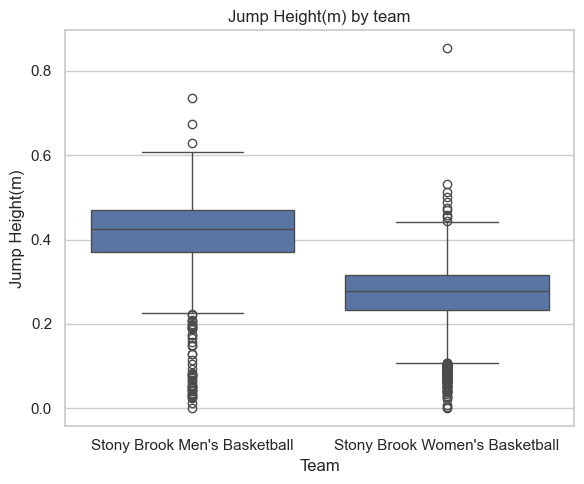

In [33]:
if not df_comp.empty:
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=df_comp, x="group", y="value")
    plt.title(f"{METRIC_FOR_COMPARISON} by team")
    plt.xlabel("Team")
    plt.ylabel(METRIC_FOR_COMPARISON)
    plt.tight_layout()
    plt.show()


In [34]:
# t-test
if (not df_men.empty) and (not df_women.empty):
    
    a_vals = df_men["value"].dropna().values
    b_vals = df_women["value"].dropna().values

    t_stat, p_val = stats.ttest_ind(a_vals, b_vals, equal_var=False)

    print("T-test for", METRIC_FOR_COMPARISON)
    print("t-statistic:", t_stat)
    print("p-value:", p_val)


T-test for Jump Height(m)
t-statistic: 76.42722555901663
p-value: 0.0


In [36]:
def clean_team_name(team):
    t = str(team)

    if "Men" in t and "Basketball" in t:
        return "Men's Basketball"
    if "Women" in t and "Basketball" in t:
        return "Women's Basketball"
    return None  # ignore all other teams


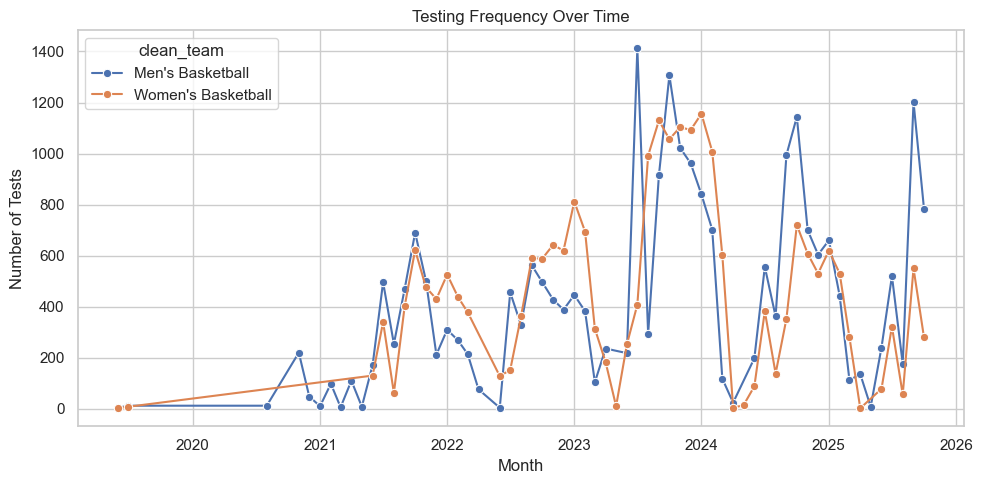

In [38]:
# analyze testing frequency over time for both teams
metrics_sql = "(" + ", ".join([f"'{m}'" for m in SELECTED_METRICS]) + ")"

query_freq = f"""
    SELECT team, timestamp
    FROM {TABLE}
    WHERE metric IN {metrics_sql}
      AND (team LIKE '%%Basketball%%')
"""

df_freq = pd.read_sql(query_freq, engine)

if not df_freq.empty:
    df_freq["timestamp"] = pd.to_datetime(df_freq["timestamp"])

    # clean messy team names
    df_freq["clean_team"] = df_freq["team"].apply(clean_team_name)
    df_freq = df_freq.dropna(subset=["clean_team"])

    # extract month
    df_freq["month"] = df_freq["timestamp"].dt.to_period("M").dt.to_timestamp()

    # count tests
    freq = (
        df_freq.groupby(["clean_team", "month"])
        .size()
        .reset_index(name="test_count")
    )

    plt.figure(figsize=(10, 5))
    sns.lineplot(
        data=freq,
        x="month",
        y="test_count",
        hue="clean_team",
        marker="o"
    )
    plt.title("Testing Frequency Over Time")
    plt.xlabel("Month")
    plt.ylabel("Number of Tests")
    plt.tight_layout()
    plt.show()

    freq.head()
else:
    print("No data found for testing frequency query.")


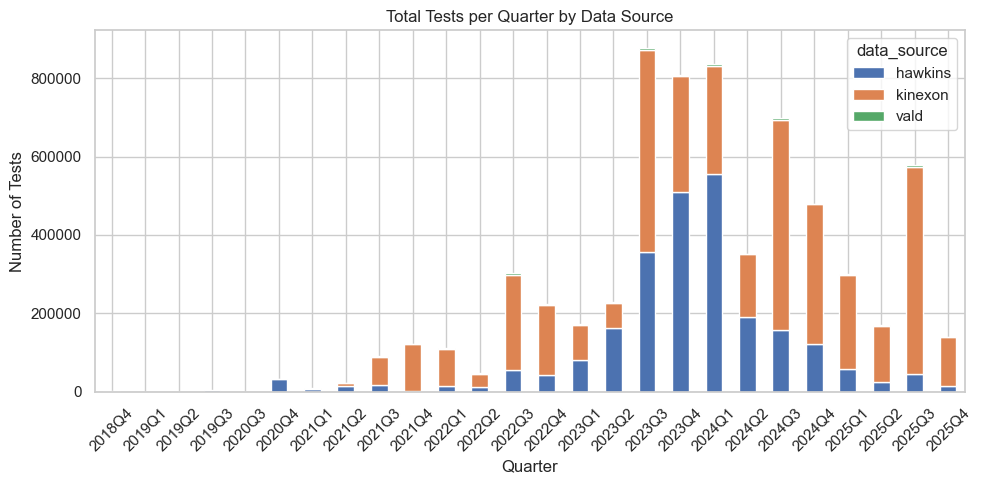

In [ ]:
# PART 3.3 – Total tests per quarter by data source (it was really slow for monthly, so quarterly for now will try again)

query_q = f"""
    SELECT
        DATE_FORMAT(timestamp, '%%Y-%%m-01') AS month_start,
        data_source,
        COUNT(*) AS test_count
    FROM {TABLE}
    WHERE timestamp IS NOT NULL
    GROUP BY month_start, data_source
    ORDER BY month_start, data_source;
"""

df_q = pd.read_sql(query_q, engine)

df_q["month_start"] = pd.to_datetime(df_q["month_start"])
df_q["quarter"] = df_q["month_start"].dt.to_period("Q").astype(str)

quarterly = (
    df_q
    .groupby(["quarter", "data_source"])["test_count"]
    .sum()
    .reset_index()
)

pivot_q = (
    quarterly
    .pivot(index="quarter", columns="data_source", values="test_count")
    .fillna(0)
)

plt.figure(figsize=(10, 5))
pivot_q.plot(kind="bar", stacked=True, ax=plt.gca())

plt.title("Total Tests per Quarter by Data Source")
plt.xlabel("Quarter")
plt.ylabel("Number of Tests")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


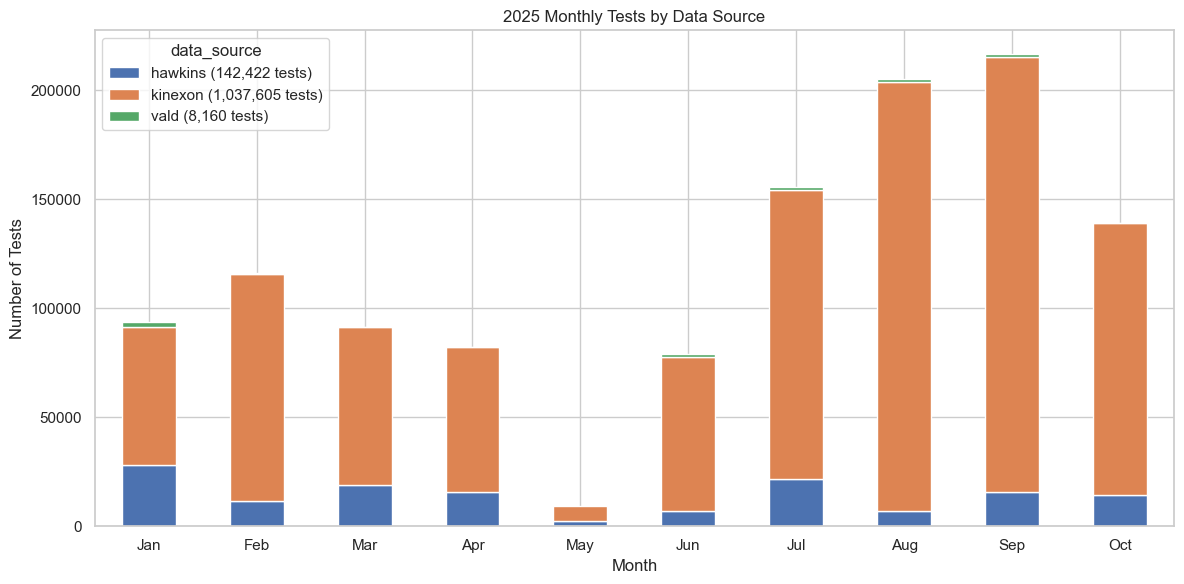

2025 Monthly Test Counts by Data Source


data_source,"hawkins (142,422 tests)","kinexon (1,037,605 tests)","vald (8,160 tests)"
Month,,,
Jan,28197.0,63231.0,2244.0
Feb,11436.0,104097.0,576.0
Mar,18722.0,72742.0,12.0
Apr,15690.0,66410.0,324.0
May,2342.0,6984.0,0.0
Jun,7162.0,70462.0,1200.0
Jul,21785.0,132454.0,1284.0
Aug,7066.0,196732.0,1188.0
Sep,15842.0,199479.0,1320.0


In [ ]:
# Attempting monthly again

#$ 2025 monthly tests by data source – cleaned up plot + table

query_2025 = f"""
    SELECT 
        DATE_FORMAT(timestamp, '%%Y-%%m-01') AS month_start,
        data_source,
        COUNT(*) AS test_count
    FROM {TABLE}
    WHERE timestamp >= '2025-01-01'
      AND timestamp < '2026-01-01'
    GROUP BY month_start, data_source
    ORDER BY month_start, data_source;
"""

df_2025 = pd.read_sql(query_2025, engine)
df_2025["month_start"] = pd.to_datetime(df_2025["month_start"])

# Pivot to month x data_source
pivot_2025 = (
    df_2025
    .pivot(index="month_start", columns="data_source", values="test_count")
    .fillna(0)
    .sort_index()
)

# Total tests per system (for legend labels) – cast to int to remove .0
totals = pivot_2025.sum(axis=0).astype(int)

# Rename columns to include total tests in legend
pivot_2025 = pivot_2025.rename(
    columns={src: f"{src} ({totals[src]:,} tests)" for src in totals.index}
)

# Plot 
plt.figure(figsize=(12, 6))
ax = pivot_2025.plot(kind="bar", stacked=True, ax=plt.gca())

# Pretty month labels: Jan, Feb, ...
ax.set_xticklabels(
    [dt.strftime("%b") for dt in pivot_2025.index],
    rotation=0
)

plt.title("2025 Monthly Tests by Data Source")
plt.xlabel("Month")
plt.ylabel("Number of Tests")
plt.tight_layout()
plt.show()

# Table of the same data
table_2025 = pivot_2025.copy()
table_2025.index = [dt.strftime("%b") for dt in table_2025.index]
table_2025.index.name = "Month"

print("2025 Monthly Test Counts by Data Source")
display(table_2025)


## Part 3.2 - Interpretation

### Jump Height Boxplot  
The boxplot showed a clear separation between the two teams. The men’s basketball team had a noticeably higher median jump height and a wider performance spread, meaning their athletes reached higher peaks and showed more variation across sessions. The women’s team stayed in a much lower range, with fewer high jump values. This suggests the men’s team consistently produced stronger vertical performance across the full testing period.

### T-Test Interpretation  
The t-test supported what was visible in the boxplot. The difference between the two teams was statistically significant, which means the higher jump heights seen in the men’s team were not random. The women’s team was consistent, but overall the men performed at a higher level. 

### Testing Frequency   
Testing frequency increased over time for both teams. Earlier seasons had fewer testing sessions and large gaps, but starting in 2022 the testing became more regular and organized. The men’s team showed more intense peaks during key training periods, while the women’s team had a steady and gradual rise in testing. Overall, both teams shifted toward more structured performance monitoring as the years progressed.


## Part 3.3 – Dashboard Interpretation

### Monthly Testing Summary  
The 2025 monthly data showed a clear and organized pattern of testing across all three systems. When the data was grouped by month, it became easier to see how testing was actually carried out through the year. Each month showed recorded activity, with higher volumes during the early training periods and steady monitoring throughout the rest of the year. Kinexon produced the largest share of tests because it runs continuously during practices and games, while Hawkins and Vald contributed regular strength, jump, and force-plate assessments. Together, the monthly view illustrated a coordinated and intentional approach to athlete monitoring.

### Gaps and Patterns in the Data  
For 2025 specifically, the data did not show any major gaps. All months had testing activity, and the distribution across systems was consistent. This was very different from earlier years in the dataset, where there were long stretches of little or no testing. The comparison suggests that the testing process became more structured and reliable over time, with 2025 representing the most complete and stable year of data collection.